In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from pathlib import Path
import pywt
from tqdm import tqdm

In [2]:
def wavelet_denoise(signal, wavelet='bior3.1', level=3, threshold_type='soft'): # pywt.wavelist(kind='discrete')
    coeffs = pywt.wavedec(signal, wavelet, mode='per', level=level)  # Decompose
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745  # Noise estimation (MAD)
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))  # Universal threshold
    coeffs_thresh = [pywt.threshold(c, threshold, mode=threshold_type) for c in coeffs]
    return pywt.waverec(coeffs_thresh, wavelet, mode='per')  # Reconstruct


from scipy.ndimage import label, binary_closing, generate_binary_structure

def detect_bouts(denoised_signal, window_size=5, closing_iterations=1, 
                 min_bout_length=10, threshold_multiplier=3):
    """
    Detect increasing/decreasing bouts in a denoised signal.
    
    Parameters:
        denoised_signal (array): Denoised 1D signal
        window_size (int): Size of smoothing window for gradient
        closing_iterations (int): Number of iterations for binary closing
        min_bout_length (int): Minimum bout duration in samples
        threshold_multiplier (float): MAD multiplier for adaptive threshold
        
    Returns:
        list: List of bout dictionaries with start/end indices and type
    """
    # Compute gradient
    slope = np.gradient(denoised_signal)
    
    # Smooth gradient
    if window_size > 1:
        kernel = np.ones(window_size)/window_size
        smoothed_slope = np.convolve(slope, kernel, mode='same')
    else:
        smoothed_slope = slope
    
    # Calculate adaptive threshold using MAD
    mad = np.median(np.abs(smoothed_slope - np.median(smoothed_slope)))
    slope_threshold = threshold_multiplier * mad
    
    # Thresholding
    increasing = smoothed_slope > slope_threshold
    decreasing = smoothed_slope < -slope_threshold
    
    # Morphological closing to merge nearby regions
    struct = generate_binary_structure(1, 1)
    increasing = binary_closing(increasing, structure=struct, iterations=closing_iterations)
    decreasing = binary_closing(decreasing, structure=struct, iterations=closing_iterations)
    
    # Label regions
    inc_labels, n_inc = label(increasing)
    dec_labels, n_dec = label(decreasing)
    
    # Extract bouts from labels
    def _get_bouts(labels, n_labels):
        bouts = []
        for i in range(1, n_labels+1):
            indices = np.where(labels == i)[0]
            if len(indices) == 0:
                continue
            start = indices[0]
            end = indices[-1]
            if (end - start + 1) >= min_bout_length:
                bouts.append((start, end))
        return bouts
    
    inc_bouts = _get_bouts(inc_labels, n_inc)
    dec_bouts = _get_bouts(dec_labels, n_dec)
    
    # Combine and format results
    all_bouts = []
    for start, end in inc_bouts:
        all_bouts.append([start, end])
    for start, end in dec_bouts:
        all_bouts.append([start, end])
    
    # Sort by start index
    all_bouts.sort(key=lambda x: x[0])
    
    return all_bouts

In [3]:
fish_dirs = glob("F:\\swim_motion_data\\2p_eyefix\\*")

fish = fish_dirs[0]
set_no = 1

fish_set = f"{fish}\\set00{set_no}"

y_motions = np.load(f"{fish_set}\\y_shift.npy")

# visualiaze

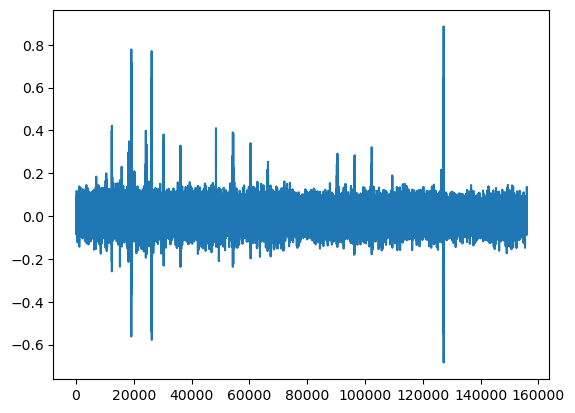

In [4]:
plt.plot(y_motions)

In [26]:
def load_old_data(fish, set_no):
    fish = fish.split('\\')[-1]
    folder = f"F:\\swim_motion_data\\size_tunning_v2\\{fish}\\set00{set_no}"
    
    old_episodes = np.load(f"{folder}\\episodes_idx.npy")
    old_y_motions = np.load(f"{folder}\\y_shift.npy")
    old_y_idx = pd.read_csv(f"{folder}\\y_shift_idx.csv")
    return old_episodes, old_y_motions, old_y_idx

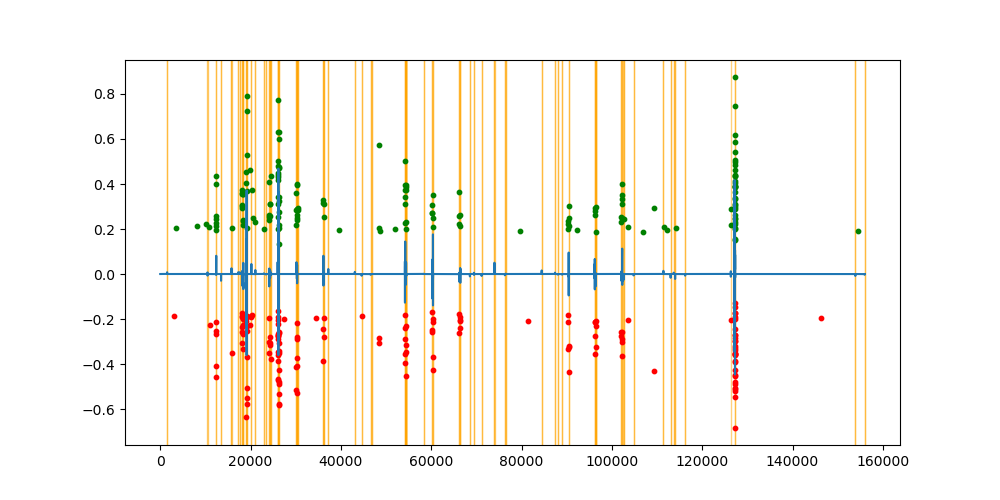

In [30]:
%matplotlib widget
old_episodes, old_y_motions, old_y_idx = load_old_data(fish, set_no)
up_idx = old_y_idx["ori"].values[old_y_idx["is_up"].values == 1]
up_values = old_y_idx["ysft"].values[old_y_idx["is_up"].values == 1]
down_idx = old_y_idx["ori"].values[old_y_idx["is_up"].values == -1]
down_values = old_y_idx["ysft"].values[old_y_idx["is_up"].values == -1]

filt_y = wavelet_denoise(y_motions)
episodes = detect_bouts(filt_y,
                        window_size=5, # Controls gradient smoothing
                        closing_iterations=10, # Controls gap merging
                        min_bout_length=10, # Filters short fluctuations
                        threshold_multiplier=6) # Adjusts sensitivity

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(filt_y)
for a, b in episodes:
    ax.axvspan(a, b, color = 'orange', alpha=0.5)
ax.scatter(up_idx, up_values, s=10, color = "green")
ax.scatter(down_idx, down_values, s=10, color = "red")

In [29]:
old_y_idx

,res,ori,ysft,is_up
0,298,3573,0.205132,1
1,682,8061,0.214110,1
2,862,10149,0.224392,1
3,913,10749,0.210250,1
4,1054,12385,0.243185,1
...,...,...,...,...
325,11401,127277,-0.271567,-1
326,11415,127291,-0.349854,-1
327,11422,127300,-0.389602,-1
328,11423,127305,-0.512434,-1


In [ ]:
up_idx = old_y_idx["ori"].values[old_y_idx["is_up"].values == 1]
up_values = old_y_idx["ysft"].values[old_y_idx["is_up"].values == 1]
down_idx = old_y_idx["ori"].values[old_y_idx["is_up"].values == -1]
down_values = old_y_idx["ysft"].values[old_y_idx["is_up"].values == -1]

In [15]:
episodes

[[np.int64(1510), np.int64(1523)],
 [np.int64(1524), np.int64(1537)],
 [np.int64(10454), np.int64(10481)],
 [np.int64(12366), np.int64(12417)],
 [np.int64(12377), np.int64(12425)],
 [np.int64(13454), np.int64(13467)],
 [np.int64(13468), np.int64(13481)],
 [np.int64(15766), np.int64(15779)],
 [np.int64(15780), np.int64(15793)],
 [np.int64(17278), np.int64(17291)],
 [np.int64(17292), np.int64(17305)],
 [np.int64(17590), np.int64(17603)],
 [np.int64(17604), np.int64(17617)],
 [np.int64(18150), np.int64(18225)],
 [np.int64(18193), np.int64(18203)],
 [np.int64(18374), np.int64(18405)],
 [np.int64(18384), np.int64(18417)],
 [np.int64(19046), np.int64(19145)],
 [np.int64(19057), np.int64(19135)],
 [np.int64(20166), np.int64(20179)],
 [np.int64(20180), np.int64(20193)],
 [np.int64(21038), np.int64(21073)],
 [np.int64(21048), np.int64(21059)],
 [np.int64(22958), np.int64(22971)],
 [np.int64(22972), np.int64(22985)],
 [np.int64(23406), np.int64(23419)],
 [np.int64(23420), np.int64(23433)],
 [np.

In [24]:
old_episodes

array([[ 12385,  12387],
       [ 12394,  12397],
       [ 12404,  12408],
       [ 12417,  12421],
       [ 15813,  15838],
       [ 18145,  18147],
       [ 18153,  18156],
       [ 18161,  18165],
       [ 18177,  18179],
       [ 18196,  18201],
       [ 18208,  18213],
       [ 18225,  18230],
       [ 18359,  18362],
       [ 18386,  18393],
       [ 18398,  18401],
       [ 19059,  19079],
       [ 19113,  19114],
       [ 19115,  19122],
       [ 19124,  19128],
       [ 19130,  19137],
       [ 19896,  19919],
       [ 20397,  20409],
       [ 24136,  24138],
       [ 24153,  24155],
       [ 24165,  24168],
       [ 24285,  24288],
       [ 24348,  24350],
       [ 24380,  24383],
       [ 24419,  24422],
       [ 26140,  26144],
       [ 26151,  26155],
       [ 26156,  26166],
       [ 26167,  26172],
       [ 26174,  26185],
       [ 26186,  26195],
       [ 26196,  26204],
       [ 26206,  26213],
       [ 26215,  26217],
       [ 26221,  26231],
       [ 30128,  30154],
